In [ ]:
import tensorflow as tf
import glob
import os
from keras import Input
import cv2
import numpy as np
import time
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, PReLU, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

In [ ]:
#from google.colab import drive

In [ ]:
#drive.mount('/content/gdrive')


In [ ]:
#!unzip /content/gdrive/MyDrive/img_align_celeba.zip

In [ ]:
residual_blocks = 16
momentum =0.8 
input_shape = (64,64,3)

In [ ]:
# Input layer to feed input to the network

input_layer = Input(shape = input_shape)

In [ ]:
# Pre residual block
gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

In [ ]:
def residual_block(x):
  '''
  Defining residual block
  '''
  filters = [64, 64]
  kernel_size = 3
  strides = 1
  padding = "same"
  momentum = 0.8
  activation = "relu"
  res = Conv2D(filters=filters[0], kernel_size=kernel_size,
  strides=strides, padding=padding)(x)
  res = Activation(activation=activation)(res)
  res = BatchNormalization(momentum=momentum)(res)
  res = Conv2D(filters=filters[1], kernel_size=kernel_size,
  strides=strides, padding=padding)(res)
  res = BatchNormalization(momentum=momentum)(res)
  # Add res and x
  res = Add()([res, x])
  return res


In [ ]:
# Add 16 residual blocks

res = residual_block(gen1)
for i in range(residual_blocks - 1):
 res = residual_block(res)

In [ ]:
def build_generator():

 """
 Create a generator network using the hyperparameter values defined below
 :return:
 """
 residual_blocks = 16
 momentum = 0.8
 input_shape = (64, 64, 3)
# Input Layer of the generator network
 input_layer = Input(shape=input_shape)
# Add the pre-residual block
 gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same',
 activation='relu')(input_layer)
  # Add 16 residual blocks
 res = residual_block(gen1)
 for i in range(residual_blocks - 1):
   res = residual_block(res)
  # Add the post-residual block
 gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
 gen2 = BatchNormalization(momentum=momentum)(gen2)
  # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
 gen3 = Add()([gen2, gen1])
  # Add an upsampling block
 gen4 = UpSampling2D(size=2)(gen3)
 gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
 gen4 = Activation('relu')(gen4)
  # Add another upsampling block
 gen5 = UpSampling2D(size=2)(gen4)
 gen5 = Conv2D(filters=256, kernel_size=3, strides=1,
 padding='same')(gen5)
 gen5 = Activation('relu')(gen5)
# Output convolution layer
 gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
 output = Activation('tanh')(gen6)
# Keras model
 model = Model(inputs=[input_layer], outputs=[output],
 name='generator')
 return model
  

In [ ]:
def build_discriminator():
 """
 Create a discriminator network using the hyperparameter values defined below
 :return:
 """

 leakyrelu_alpha = 0.2
 input_shape = (256,256,3)


# Firrst input llayer for Disc

 input_layer = Input(shape=input_shape)

# Add convolution blocks
 dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
 dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)


# Seven inner blocks for DIsc

 dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
 dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
 dis2 = BatchNormalization(momentum=momentum)(dis2)
# Add the third convolution block
 dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
 dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
 dis3 = BatchNormalization(momentum=momentum)(dis3)
# Add the fourth convolution block
 dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
 dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
 dis4 = BatchNormalization(momentum=0.8)(dis4)
# Add the fifth convolution block
 dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
 dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
 dis5 = BatchNormalization(momentum=momentum)(dis5)
# Add the sixth convolution block
 dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
 dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
 dis6 = BatchNormalization(momentum=momentum)(dis6)
# Add the seventh convolution block
 dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
 dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
 dis7 = BatchNormalization(momentum=momentum)(dis7)
# Add the eight convolution block
 dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
 dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
 dis8 = BatchNormalization(momentum=momentum)(dis8)


# Dense layer with 1024 neurons 

 dis9 = Dense(units=1024)(dis8)
 dis9 = LeakyReLU(alpha=0.2)(dis9)

# Last dense layer with sigmoid activation for prediction
 output = Dense(units=1, activation='sigmoid')(dis9)
 # call model
 model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
 return model

In [ ]:
# Load and extract feature using VGG19 Network

def build_vgg():
 """
 Build the VGG network to extract image features
 """
 input_shape = (256, 256, 3)
 # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
 vgg = VGG19(weights="imagenet", include_top=False)
 input_layer = Input(shape=input_shape)
 vgg.outputs = [vgg.layers[9].output]
 # Extract features
 features = vgg(input_layer)
 # Create a Keras model
 model = Model(inputs=[input_layer], outputs=[features])
 return model

In [ ]:
# Adversarial network for loss

def build_adversarial_model(generator, discriminator, vgg):
 input_low_resolution = Input(shape=(64, 64, 3))
 fake_hr_images = generator(input_low_resolution)
 fake_features = vgg(fake_hr_images)
 discriminator.trainable = False
 output = discriminator(fake_hr_images)
 model = Model(inputs=[input_low_resolution],
 outputs=[output, fake_features])
 for layer in model.layers:
  print(layer.name, layer.trainable)
  print(model.summary())
 return model

In [ ]:
data_dir = "/content/img_align_celeba/*.*"
epochs =400
batch_size = 1
# Shape of low-resolution and high-resolution images
low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)
common_optimizer = Adam(0.0002, 0.5)

In [ ]:
# Build and compile VGG19 network
vgg = VGG19(weights="imagenet",include_top=False, input_shape=(256, 256, 3))
model = Model(inputs=vgg.inputs, outputs=vgg.layers[9].output)
vgg = model
vgg.trainable = False
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=
 ['accuracy'])


# bUild and compile discriminator network

discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=common_optimizer,
 metrics=['accuracy'])

#discriminator.load_weights("/content/gdrive/MyDrive/Machine Learning Project/dis4.h5")


# build generator

generator = build_generator()
#generator.load_weights("/content/gdrive/MyDrive/Machine Learning Project/gen4.h5")

# create adversarial model by creating two layers

input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)


# Generate high resolution using Generator
generated_high_resolution_images = generator(input_low_resolution)

# Use VGG19 to extaract the features
features = vgg(generated_high_resolution_images)

# make discriminator non  trainable
discriminator.trainable = False

# Generator prediction on the fake images
probs = discriminator(generated_high_resolution_images)

# Compile adversarial network

adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

# Visualize using tensorboard

tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
tensorboard.set_model(generator)
tensorboard.set_model(discriminator)



            
  

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# Code to generate low and high resolution images

def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):


# Make a list of all images inside the data directory
  all_images = glob.glob(data_dir)
  # Choose a random batch of images
  images_batch = np.random.choice(all_images, size=batch_size)
  low_resolution_images = []
  high_resolution_images = []
  for img in images_batch:
  # Get an ndarray of the current image
    img1 = cv2.imread(img)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = np.asarray(img1)
    img1 = img1.astype(np.float32)
  # Resize the image
  from skimage.transform import resize                    
  
  img1_high_resolution = resize(img1, high_resolution_shape)
  img1_low_resolution = resize(img1, low_resolution_shape)
  # Do a random flip
  if np.random.random() < 0.5:
    img1_high_resolution = np.fliplr(img1_high_resolution)
    img1_low_resolution = np.fliplr(img1_low_resolution)
  high_resolution_images.append(img1_high_resolution)
  low_resolution_images.append(img1_low_resolution)
  return np.array(high_resolution_images),np.array(low_resolution_images)


Epoch:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


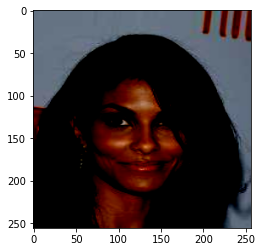

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


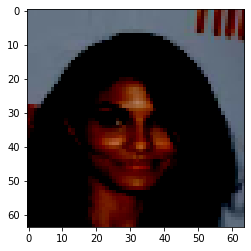

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


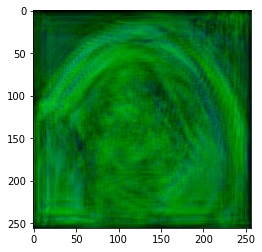

Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50
Epoch:51
Epoch:52
Epoch:53
Epoch:54
Epoch:55
Epoch:56
Epoch:57
Epoch:58
Epoch:59
Epoch:60
Epoch:61
Epoch:62
Epoch:63
Epoch:64
Epoch:65
Epoch:66
Epoch:67
Epoch:68
Epoch:69
Epoch:70
Epoch:71
Epoch:72
Epoch:73
Epoch:74
Epoch:75
Epoch:76
Epoch:77
Epoch:78
Epoch:79
Epoch:80
Epoch:81
Epoch:82
Epoch:83
Epoch:84
Epoch:85
Epoch:86
Epoch:87
Epoch:88
Epoch:89
Epoch:90
Epoch:91
Epoch:92
Epoch:93
Epoch:94
Epoch:95
Epoch:96
Epoch:97
Epoch:98
Epoch:99
Epoch:100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


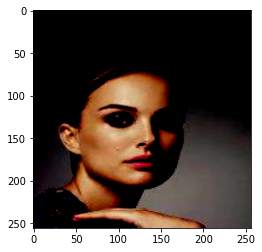

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


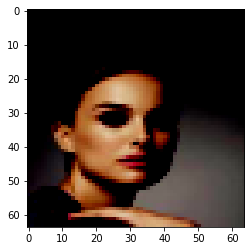

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


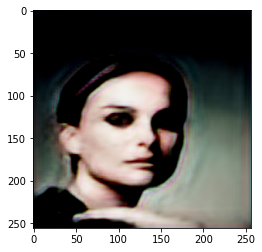

Epoch:101
Epoch:102
Epoch:103
Epoch:104
Epoch:105
Epoch:106
Epoch:107
Epoch:108
Epoch:109
Epoch:110
Epoch:111
Epoch:112
Epoch:113
Epoch:114
Epoch:115
Epoch:116
Epoch:117
Epoch:118
Epoch:119
Epoch:120
Epoch:121
Epoch:122
Epoch:123
Epoch:124
Epoch:125
Epoch:126
Epoch:127
Epoch:128
Epoch:129
Epoch:130
Epoch:131
Epoch:132
Epoch:133
Epoch:134
Epoch:135
Epoch:136
Epoch:137
Epoch:138
Epoch:139
Epoch:140
Epoch:141
Epoch:142
Epoch:143
Epoch:144
Epoch:145
Epoch:146
Epoch:147
Epoch:148
Epoch:149
Epoch:150
Epoch:151
Epoch:152
Epoch:153
Epoch:154
Epoch:155
Epoch:156
Epoch:157
Epoch:158
Epoch:159
Epoch:160
Epoch:161
Epoch:162
Epoch:163
Epoch:164
Epoch:165
Epoch:166
Epoch:167
Epoch:168
Epoch:169
Epoch:170
Epoch:171
Epoch:172
Epoch:173
Epoch:174
Epoch:175
Epoch:176
Epoch:177
Epoch:178
Epoch:179
Epoch:180
Epoch:181
Epoch:182
Epoch:183
Epoch:184
Epoch:185
Epoch:186
Epoch:187
Epoch:188
Epoch:189
Epoch:190
Epoch:191
Epoch:192
Epoch:193
Epoch:194
Epoch:195
Epoch:196
Epoch:197
Epoch:198
Epoch:199
Epoch:200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


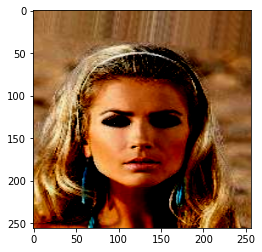

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


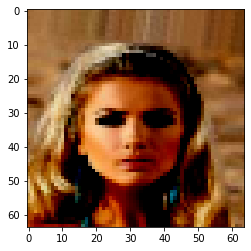

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


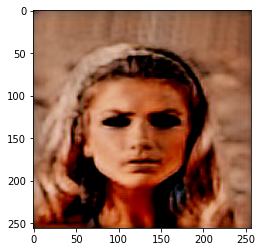

Epoch:201
Epoch:202
Epoch:203
Epoch:204
Epoch:205
Epoch:206
Epoch:207
Epoch:208
Epoch:209
Epoch:210
Epoch:211
Epoch:212
Epoch:213
Epoch:214
Epoch:215
Epoch:216
Epoch:217
Epoch:218
Epoch:219
Epoch:220
Epoch:221
Epoch:222
Epoch:223
Epoch:224
Epoch:225
Epoch:226
Epoch:227
Epoch:228
Epoch:229
Epoch:230
Epoch:231
Epoch:232
Epoch:233
Epoch:234
Epoch:235
Epoch:236
Epoch:237
Epoch:238
Epoch:239
Epoch:240
Epoch:241
Epoch:242
Epoch:243
Epoch:244
Epoch:245
Epoch:246
Epoch:247
Epoch:248
Epoch:249
Epoch:250
Epoch:251
Epoch:252
Epoch:253
Epoch:254
Epoch:255
Epoch:256
Epoch:257
Epoch:258
Epoch:259
Epoch:260
Epoch:261
Epoch:262
Epoch:263
Epoch:264
Epoch:265
Epoch:266
Epoch:267
Epoch:268
Epoch:269
Epoch:270
Epoch:271
Epoch:272
Epoch:273
Epoch:274
Epoch:275
Epoch:276
Epoch:277
Epoch:278
Epoch:279
Epoch:280
Epoch:281
Epoch:282
Epoch:283
Epoch:284
Epoch:285
Epoch:286
Epoch:287
Epoch:288
Epoch:289
Epoch:290
Epoch:291
Epoch:292
Epoch:293
Epoch:294
Epoch:295
Epoch:296
Epoch:297
Epoch:298
Epoch:299
Epoch:300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


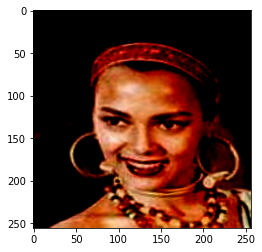

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


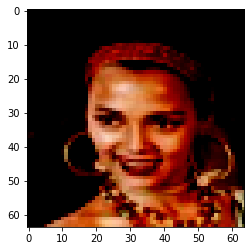

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


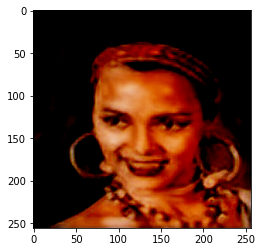

Epoch:301
Epoch:302
Epoch:303
Epoch:304
Epoch:305
Epoch:306
Epoch:307
Epoch:308
Epoch:309
Epoch:310
Epoch:311
Epoch:312
Epoch:313
Epoch:314
Epoch:315
Epoch:316
Epoch:317
Epoch:318
Epoch:319
Epoch:320
Epoch:321
Epoch:322
Epoch:323
Epoch:324
Epoch:325
Epoch:326
Epoch:327
Epoch:328
Epoch:329
Epoch:330
Epoch:331
Epoch:332
Epoch:333
Epoch:334
Epoch:335
Epoch:336
Epoch:337
Epoch:338
Epoch:339
Epoch:340
Epoch:341
Epoch:342
Epoch:343
Epoch:344
Epoch:345
Epoch:346
Epoch:347
Epoch:348
Epoch:349
Epoch:350
Epoch:351
Epoch:352
Epoch:353
Epoch:354
Epoch:355
Epoch:356
Epoch:357
Epoch:358
Epoch:359
Epoch:360
Epoch:361
Epoch:362
Epoch:363
Epoch:364
Epoch:365
Epoch:366
Epoch:367
Epoch:368
Epoch:369
Epoch:370
Epoch:371
Epoch:372
Epoch:373
Epoch:374
Epoch:375
Epoch:376
Epoch:377
Epoch:378
Epoch:379
Epoch:380
Epoch:381
Epoch:382
Epoch:383
Epoch:384
Epoch:385
Epoch:386
Epoch:387
Epoch:388
Epoch:389
Epoch:390
Epoch:391
Epoch:392
Epoch:393
Epoch:394
Epoch:395
Epoch:396
Epoch:397
Epoch:398
Epoch:399


In [ ]:
for epoch in range(epochs):
 print("Epoch:{}".format(epoch))
 high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir,
 batch_size=batch_size,low_resolution_shape=low_resolution_shape,
 high_resolution_shape=high_resolution_shape)

# Code to generate low and high resolution images

 
 #print(high_resolution_images.shape, low_resolution_images.shape)
 # normalization

 high_resolution_images = high_resolution_images / 127.5 - 1.
 low_resolution_images = low_resolution_images / 127.5 - 1.

 generated_high_resolution_images = generator.predict(low_resolution_images)

 real_labels = np.ones((batch_size, 16, 16, 1))
 fake_labels = np.zeros((batch_size, 16, 16, 1))

 d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
 d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

 d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

 high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,high_resolution_shape=high_resolution_shape,low_resolution_shape=low_resolution_shape)

 # Normalize images
 high_resolution_images = high_resolution_images / 127.5 - 1.
 low_resolution_images = low_resolution_images / 127.5 - 1.
 image_features = vgg.predict(high_resolution_images)

 g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features])
 #write_log(tensorboard, 'g_loss', g_loss[0], epoch)
 #write_log(tensorboard, 'd_loss', d_loss[0], epoch)




 if epoch % 100 == 0:
  high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size = batch_size,
  high_resolution_shape=high_resolution_shape,low_resolution_shape=low_resolution_shape)
  # Normalize images
  high_resolution_images = high_resolution_images / 127.5 - 1.
  low_resolution_images = low_resolution_images / 127.5 - 1.

  # Generate fake high-resolution images
  generated_images = generator.predict_on_batch(low_resolution_images)

  checkpoint_dir = '/content/gdrive/MyDrive/Machine Learning Project'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=common_optimizer,
                                 discriminator_optimizer=common_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
  
  checkpoint.save(file_prefix=checkpoint_prefix)

  #fig=plt.figure()

 # Save
  for index, img in enumerate(generated_images):

    #fig.add_subplot(1, 3 , 1)

    plt.imshow(high_resolution_images[index])
    plt.show()
    
   # fig.add_subplot(1, 3 , 2)
    plt.imshow(low_resolution_images[index])
    plt.show()
    #fig.add_subplot(1, 3 , 3)
    plt.imshow(generated_images[index])
    plt.show()

    
    
    #torchvision.utils.save_image(high_resolution_images[index], "/content/images_saved/" + str(index))
  #  save_images(low_resolution_images[index], high_resolution_images[index], img, path="results/img_{}_{}".format(epoch, index))
#if cur_step % display_step == 0 and cur_step >= 0:
  #print('Step {}: SRResNet loss: {:.5f}'.format(cur_step, mean_loss))





In [ ]:
#generator.save("/content/gdrive/MyDrive/Machine Learning Project/gen5.h5")
#discriminator.save("/content/gdrive/MyDrive/Machine Learning Project/dis5.h5")

# New Section